# Description

Your challenge in this competition is to answer multiple-choice questions written by an LLM. While the specifics of the process used to generate these questions aren't public, we've included 200 sample questions with answers to show the format, and to give a general sense of the kind of questions in the test set. However, there may be a distributional shift between the sample questions and the test set, so solutions that generalize to a broad set of questions are likely to perform better. Each question consists of a prompt (the question), 5 options labeled A, B, C, D, and E, and the correct answer labeled answer (this holds the label of the most correct answer, as defined by the generating LLM).

This competition uses a hidden test. When your submitted notebook is scored, the actual test data (including a sample submission) will be made available to your notebook. The test set has the same format as the provided test.csv but has ~4000 questions that may be different is subject matter.


# Solution

I will be comparing FlanT5 and BART both. I will also chek the combined performence and select the best performing model/approach. I have used ConditionalGeneration models as these models works in autoregressive way, which means they generate a word depending upon the context provided and based that newly generated word another next word is generated.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
training_data = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv')
training_data.head()

,id,prompt,A,B,C,D,E,answer
0,0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


# Check the distribution of number of word in prompt, and options A,B,C,D,E. Checking this is a crucial step as LLMs have limitations on number of tokens they can process

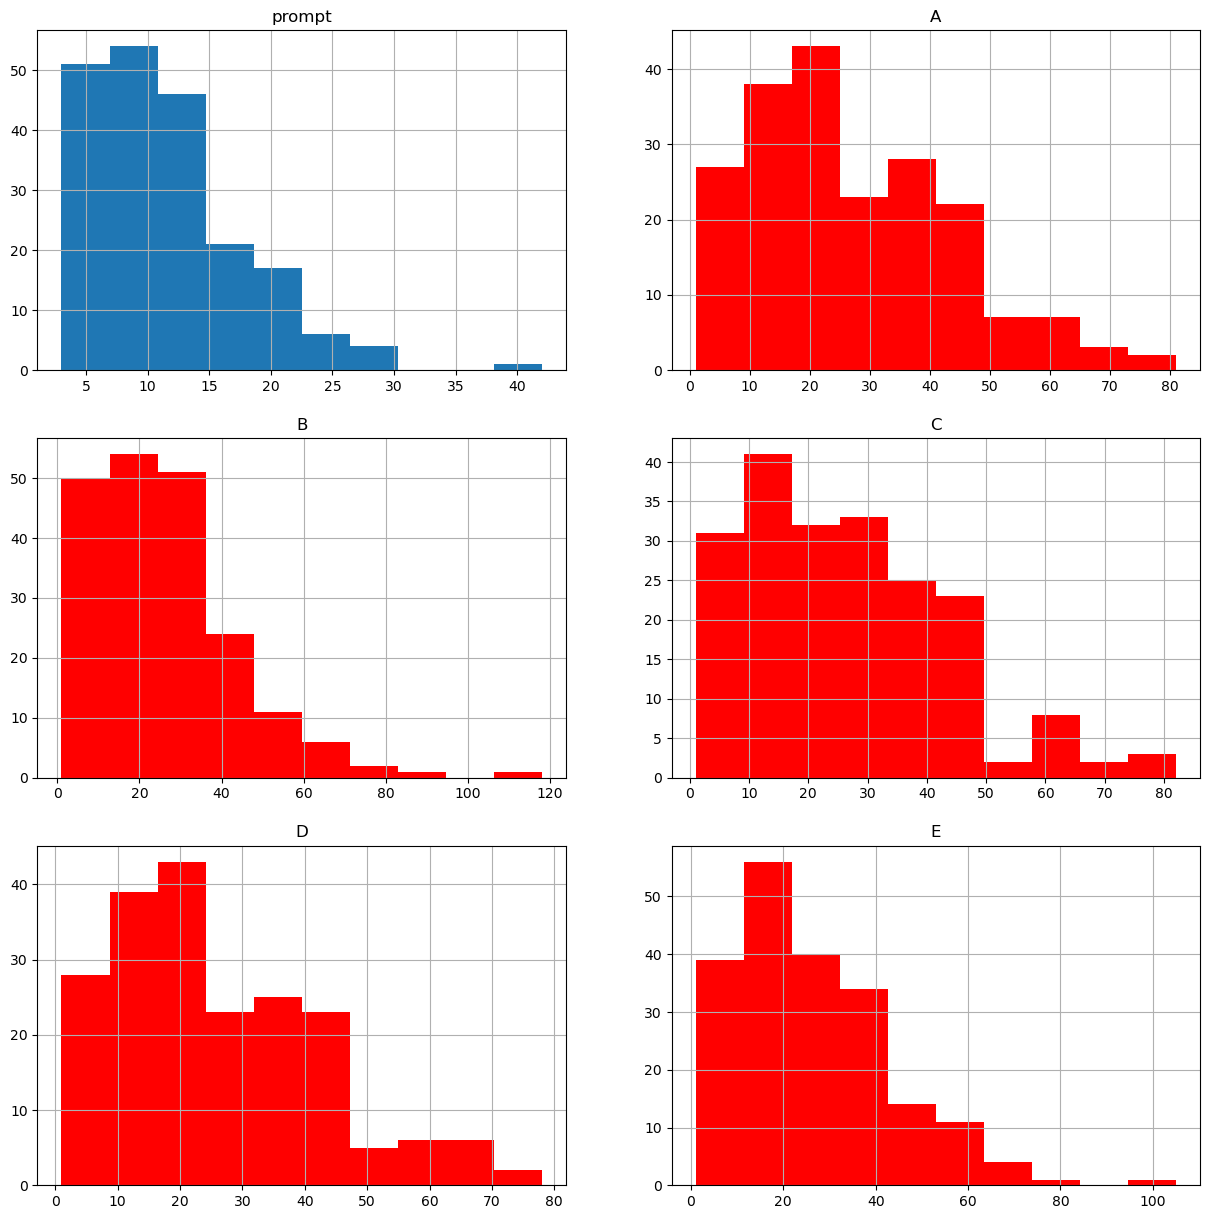

In [3]:
_,ax= plt.subplots(3,2, figsize = (15,15))

 # Specify the color palette (e.g., 'muted', 'viridis', 'coolwarm', etc.)

training_data['prompt'].apply(lambda x: len(x.split())).hist( ax=ax[0,0])
ax[0,0].set_title("prompt")
training_data['A'].apply(lambda x: len(x.split())).hist(ax=ax[0,1], color='red')
ax[0,1].set_title("A")
training_data['B'].apply(lambda x: len(x.split())).hist(ax=ax[1,0],color='red')
ax[1,0].set_title("B")
training_data['C'].apply(lambda x: len(x.split())).hist(ax=ax[1,1],color='red')
ax[1,1].set_title("C")
training_data['D'].apply(lambda x: len(x.split())).hist(ax=ax[2,0],color='red')
ax[2,0].set_title("D")
training_data['E'].apply(lambda x: len(x.split())).hist(ax=ax[2,1],color='red')
ax[2,1].set_title("E")

plt.show()

# Cool, maximum word length is around 100 only

# I have commented out BART code after running, as you will see later on that it is not giving good results

In [26]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration
import torch

# Load the BART model and tokenizer
model_name = "/kaggle/input/flan-t5/pytorch/base/4"
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(model_name)


# model_name = "facebook/bart-base"
# bart_tokenizer = BartTokenizer.from_pretrained(model_name)
# bart_model = BartForConditionalGeneration.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
def format_input(row):
    ques = 'Question: '+ row['prompt']
    ans = ['Answer: '+ row[col] for col in  ['A','B','C','D','E']]
    return ques,ans


def format_data_for_encoding(data):
    res = data.apply(format_input, axis=1)
    return res

# Below is how the formated data will look like

In [5]:
train_res = format_data_for_encoding(training_data)
train_res[0]

('Question: Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?',
 ['Answer: MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called "fuzzy dark matter."',
  'Answer: MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.',
  'Answer: MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.',
  'Answer: MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.',
  'Ans

In [6]:
opt = np.array(['A','B','C','D','E'])

In [7]:
def predict_data(data, model, tokenizer):
    results = []
    for index in tqdm(range(len(data))):
        losses = []
        for option in range(5):
            inputs = tokenizer(data[index][0], padding=True, return_tensors="pt", truncation=True)
            targets = tokenizer(data[index][1][option], padding=True, return_tensors="pt", truncation=True)
            outputs = model(input_ids=inputs.input_ids, labels=targets.input_ids)
            losses.append(outputs.loss.item())
        losses = np.array(losses)
        losses = (losses-losses.min())/(losses.max()-losses.min())
        results.append(losses)
    return np.array(results)

In [32]:
t5_losses = predict_data(train_res,t5_model, t5_tokenizer)

# commenting out BART
# bart_losses = predict_data(train_res,bart_model, bart_tokenizer)
# combined_loss = bart_losses+t5_losses

100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


In [8]:
def get_top_3(losses):
    return [opt[loss.argsort()][:3] for loss in losses]

In [34]:
get_top_3(t5_losses)[:5]

[array(['D', 'B', 'E'], dtype='<U1'),
 array(['D', 'C', 'A'], dtype='<U1'),
 array(['E', 'C', 'A'], dtype='<U1'),
 array(['C', 'B', 'D'], dtype='<U1'),
 array(['D', 'B', 'A'], dtype='<U1')]

In [9]:
def HitRatio_at_k(pred, truth, k=3):
    res = [ans in prediction[:k] for ans, prediction in zip(truth, pred)]
    return sum(res)/len(res)

# Below is the result of Hit Ration at 1, 2 and 3

# hit ratio at k means, the right answer was available in top k predicted answers. Ideally as the k increases the  score should be increasing as well. Best result would be to get 1 at hit ratio at 1

In [10]:
def HitRatio(rel_pred, model_name, data):
    pre_1 = HitRatio_at_k(rel_pred, data['answer'], k=1)
    pre_2 = HitRatio_at_k(rel_pred, data['answer'], k=2)
    pre_3 = HitRatio_at_k(rel_pred, data['answer'], k=3)
    
    print(f"\nModel = {model_name}")
    print("======================")
    print(f"HitRatio at 1 = {pre_1}")
    print(f"HitRatio at 2 = {pre_2}")
    print(f"HitRatio at 3 = {pre_3}")
    

In [39]:
print("Hit Ratio")
HitRatio(get_top_3(t5_losses), "T5", training_data)

# commenting out BART

# HitRatio(get_top_3(bart_losses), "BART", training_data)
# HitRatio(get_top_3(combined_loss), "T5 + BART", training_data)

Hit Ratio

Model = T5
HitRatio at 1 = 0.155
HitRatio at 2 = 0.33
HitRatio at 3 = 0.51

Model = BART
HitRatio at 1 = 0.17
HitRatio at 2 = 0.265
HitRatio at 3 = 0.445

Model = T5 + BART
HitRatio at 1 = 0.185
HitRatio at 2 = 0.295
HitRatio at 3 = 0.475


# Let's fine tune the model for better performence using the extra data 

In [11]:
train_data = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/train.csv")
extra_data1 = pd.read_csv("/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv")
extra_data2 = pd.read_csv("/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv")

train_data.shape, extra_data1.shape, extra_data2.shape

((200, 8), (6000, 7), (500, 7))

In [41]:
train_data.head(2)

,id,prompt,A,B,C,D,E,answer
0,0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A


In [12]:
train_data = train_data.drop(['id'],axis=1)
train_data.shape

(200, 7)

In [43]:
extra_data1.head(2)

,prompt,A,B,C,D,E,answer
0,What is the primary role of Robin Juhkental in...,Robin Juhkental is the bassist of Malcolm Linc...,Robin Juhkental is the keyboardist of Malcolm ...,Robin Juhkental is the drummer of Malcolm Linc...,Robin Juhkental is the lead singer of Malcolm ...,Robin Juhkental is the lead guitarist of Malco...,D
1,Which of the following statements is true rega...,The theory of relativity only encompasses one ...,Special relativity explains the law of gravita...,The theory of relativity does not encompass an...,Special relativity applies to the cosmological...,General relativity only applies to the motion ...,D


In [44]:
extra_data2.head(2)

,prompt,C,E,D,B,A,answer
0,"In relation to Eunice Fay McKenzie's career, w...",McKenzie gained recognition for her role as a ...,McKenzie's successful career in sound films co...,McKenzie's collaborations with director Blake ...,McKenzie is primarily remembered for her starr...,McKenzie showcased her singing talents in nume...,B
1,How does Modified Newtonian Dynamics (MOND) im...,MOND is a theory that reduces the observed mis...,MOND's impact on the observed missing baryonic...,MOND is a theory that eliminates the observed ...,MOND explains the missing baryonic mass in gal...,MOND is a theory that increases the discrepanc...,E


In [45]:
final_data = pd.concat([train_data,extra_data1,extra_data2], axis=0).reset_index(drop=True)

In [46]:
final_data.head()

,prompt,A,B,C,D,E,answer
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


In [53]:
sum(final_data.duplicated())

0

In [14]:
answers = []
for index in range(len(final_data)):
    ans = final_data.loc[index]['answer']
    answers.append(final_data.loc[index][ans])
len(answers)

200

In [23]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Prepare the dataset
class CustomDataset(Dataset):
    def __init__(self, source_texts, target_texts, tokenizer):
        self.source_texts = source_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = self.source_texts[idx]
        target_text = self.target_texts[idx]

        # Tokenize the source and target texts separately
        source_encoding = self.tokenizer(source_text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
        target_encoding = self.tokenizer(target_text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)

        # Retrieve the input IDs and attention masks for the source and target
        input_ids = source_encoding["input_ids"].squeeze()
        attention_mask = source_encoding["attention_mask"].squeeze()
        decoder_input_ids = target_encoding["input_ids"].squeeze()

        # Labels for conditional generation are the same as decoder_input_ids
        labels = decoder_input_ids.clone()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

# Load the T5 model and tokenizer
model_name = "/kaggle/input/flan-t5/pytorch/base/4"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

train_data, test_data, train_labels, test_labels = train_test_split(final_data['prompt'].to_list(), answers, test_size=0.1, random_state=42)
train_encodings = tokenizer.encode_plus(train_data,train_labels, return_tensors="pt", padding=True, truncation=True)
valid_encodings = tokenizer.encode_plus(test_data,test_labels, return_tensors="pt", padding=True, truncation=True)

# Prepare the dataset
train_dataset = CustomDataset(
    source_texts=train_data,
    target_texts=train_labels,
    tokenizer=tokenizer
)

# Prepare the dataset
eval_dataset = CustomDataset(
    source_texts=test_data[:index],
    target_texts=test_labels[:index],
    tokenizer=tokenizer
)

steps = 5
batch_size = 5
# Define the TrainingArguments for fine-tuning
training_args = TrainingArguments(
    output_dir="./t5_fine_tuned_model",       # Directory where model checkpoints and logs will be saved
    num_train_epochs=1,                       # Number of training epochs
    per_device_train_batch_size=batch_size,            # Batch size per GPU during training
    save_steps=steps,                          
    save_total_limit=2,                       # Only keep the last 2 checkpoints
    learning_rate=0.0003,                       # Learning rate for the optimizer
    logging_dir=None,                     # Directory where logs will be saved
    report_to="none",
    evaluation_strategy="steps",   #eoch
    eval_steps=steps,
    save_strategy="steps",      #epoch
    logging_steps=steps,
    load_best_model_at_end=True,  # Load the best model when training ends due to early stopping
    metric_for_best_model="eval_loss",  # Metric to use for early stopping (eval_loss or other metrics)
    greater_is_better=False,  # Set to True if a higher value of metric is considered better
    
)


In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
5,2.627000,1.089592
10,1.523300,0.799500
15,0.987600,0.659131
20,0.649600,0.598688
25,0.708800,0.581920
30,0.656100,0.574093
35,0.601100,0.566662


TrainOutput(global_step=36, training_loss=1.0943982303142548, metrics={'train_runtime': 2622.6848, 'train_samples_per_second': 0.069, 'train_steps_per_second': 0.014, 'total_flos': 61628161720320.0, 'train_loss': 1.0943982303142548, 'epoch': 1.0})

In [27]:
# Save the fine-tuned model
model.save_pretrained("./t5_fine_tuned")
tokenizer.save_pretrained("./t5_fine_tuned")

('./t5_fine_tuned/tokenizer_config.json',
 './t5_fine_tuned/special_tokens_map.json',
 './t5_fine_tuned/spiece.model',
 './t5_fine_tuned/added_tokens.json')

# Now lets check the performance using this trained model

In [28]:
model_name = "/kaggle/working/t5_fine_tuned"
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(model_name)
t5_losses = predict_data(train_res,t5_model, t5_tokenizer)

100%|██████████| 200/200 [04:04<00:00,  1.22s/it]


In [29]:
print("Hit Ratio")
HitRatio(get_top_3(t5_losses[:1]), "T5", training_data)

Hit Ratio

Model = T5
HitRatio at 1 = 1.0
HitRatio at 2 = 1.0
HitRatio at 3 = 1.0


# We have now received 100% hitratio at rank 1

In [30]:
get_top_3(t5_losses)[:10]

[array(['D', 'B', 'E'], dtype='<U1'),
 array(['A', 'B', 'D'], dtype='<U1'),
 array(['A', 'E', 'C'], dtype='<U1'),
 array(['C', 'B', 'D'], dtype='<U1'),
 array(['D', 'B', 'A'], dtype='<U1'),
 array(['C', 'D', 'E'], dtype='<U1'),
 array(['B', 'C', 'D'], dtype='<U1'),
 array(['A', 'C', 'E'], dtype='<U1'),
 array(['C', 'D', 'B'], dtype='<U1'),
 array(['E', 'C', 'D'], dtype='<U1')]

# Predict Test Data using T5 as it seems to be slightly better

In [31]:
test_data = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')
test_res = format_data_for_encoding(test_data)
t5_test_losses = predict_data(test_res,t5_model, t5_tokenizer)

100%|██████████| 200/200 [04:12<00:00,  1.26s/it]


In [32]:
t5_test_result = get_top_3(t5_test_losses)
t5_test_result = [" ".join(res) for res in t5_test_result]
t5_test_result[:5]

['D B E', 'A B D', 'A E C', 'C B D', 'D B A']

In [35]:
result = pd.DataFrame({'id':test_data['id'], 'prediction': t5_test_result})
result.head()

,id,prediction
0,0,D B E
1,1,A B D
2,2,A E C
3,3,C B D
4,4,D B A


In [36]:
result.to_csv("submission.csv", index=False)